In [2]:
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
from torchvision import utils,datasets
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingWarmRestarts
from torchsummary import summary
import logging
import os 

In [3]:
# importing module
import logging

# Create and configure logger
logging.basicConfig(filename="newfile1.log",
					format='%(asctime)s %(message)s',
					filemode='w')

# Creating an object
logger = logging.getLogger()

# Setting the threshold of logger to DEBUG
logger.setLevel(logging.DEBUG)

logger.info("Just an information")



In [4]:
import torchvision
import torchvision.transforms as transforms
## Load the datasets

original_set = torchvision.datasets.MNIST(root="./", download=True, 
                                              train=True,
                                              transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(0,1)]))

test_set = torchvision.datasets.MNIST(root="./", download=True, 
                                              train=False,
                                              transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0,1)]))

from torch.utils.data import random_split, Dataset, DataLoader

## Train-val split
train_set, val_set = random_split(original_set, [50000, 10000])

print(f"Size of the training set: {len(train_set)}")
print(f"Size of the validation set: {len(val_set)}")
print(f"Size of the test set: {len(test_set)}")

## Create the data loaders
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
val_loader = DataLoader(val_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=True) 

Size of the training set: 50000
Size of the validation set: 10000
Size of the test set: 10000


In [6]:
def fit(clf,
        train_loader,
        optimizer,
        criterian,
        scheduler):

    clf.train()
    training_loss_running = 0
    training_correct_running = 0
    total = 0
    counter = 0
    for i,data in enumerate(train_loader):
        counter += 1
        data,label = data[0],data[1]
        #data = data.reshape(-1,28*28)
        total += label.size(0)
        optimizer.zero_grad()
        out = clf(data)
        loss = criterian(out,label)
        training_loss_running += loss.item()
        _,pred = torch.max(out.data,1)
        training_correct_running += (pred == label).sum().item()
        loss.backward()
        optimizer.step()
    scheduler.step() 
    train_loss = training_loss_running / counter
    train_accuracy = 100. * training_correct_running / total
    return train_loss, train_accuracy     


In [8]:
def validation (clf,validation_loader,criterian,epoch):
    clf.eval()
    valid_loss_running = 0
    valid_acc_running = 0
    total = 0
    counter = 0
    for i,data in enumerate(validation_loader):
        counter += 1
        data,label = data[0],data[1]
        #data = data.reshape(-1,28*28)
        total += label.size(0)
        out = clf(data)
        loss = criterian(out,label)
        valid_loss_running += loss.item()
        _,pred = torch.max(out.data,1)
        valid_acc_running += (pred == label).sum().item()

    valid_loss = valid_loss_running / counter
    valid_acc = 100. * valid_acc_running / total  
    chk.save(valid_acc,'chk',epoch,clf)
      

    return valid_loss,valid_acc


        


In [9]:
def train (hyparam,train_loader,val_loader):

    clf = LeNet()
    optimizer = torch.optim.Adam(clf.parameters(), lr =hyparam['lr'])
    criterian = nn.CrossEntropyLoss()
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=1)

    train_loss =[]
    train_acc =[]
    val_loss =[]
    val_acc = []
    
    for epoch in range(hyparam['epoch']):
        print(f"Epoch {epoch+1} of {hyparam['epoch']}")
        training_loss,training_acc = fit(clf,train_loader,optimizer,criterian,scheduler)
        validation_loss,validation_acc = validation(clf,val_loader,criterian,epoch)

        train_loss.append(training_loss)
        train_acc.append(training_acc)

        val_loss.append(validation_loss)
        val_acc.append(validation_acc)

        

        logger.info(f" Epoch: {epoch + 1}, Train Loss: {training_loss:.4f}, Train Acc: {training_acc:.2f},\
         Val Loss: {validation_loss:.4f}, Val Acc: {validation_acc:.2f}")
       
        print(f"Train Loss: {training_loss:.4f}, Train Acc: {training_acc:.2f},\
         Val Loss: {validation_loss:.4f}, Val Acc: {validation_acc:.2f}")



      
    return clf,train_loss,train_acc,val_loss,val_acc
        



In [13]:
hparams = {'batch_size': 256, 'lr': 6e-4, 'epoch': 10} #6e-4
clf,train_loss,train_acc,val_loss,val_acc = train(hparams,train_loader,val_loader)   

Epoch 1 of 10
Train Loss: 0.9646, Train Acc: 69.73,         Val Loss: 0.2783, Val Acc: 91.58
Epoch 2 of 10
Train Loss: 0.2227, Train Acc: 93.41,         Val Loss: 0.1867, Val Acc: 94.06
Epoch 3 of 10
Train Loss: 0.1580, Train Acc: 95.29,         Val Loss: 0.1387, Val Acc: 95.66
Epoch 4 of 10
Train Loss: 0.1231, Train Acc: 96.33,         Val Loss: 0.1124, Val Acc: 96.56
Epoch 5 of 10
Train Loss: 0.1017, Train Acc: 96.98,         Val Loss: 0.0926, Val Acc: 97.13
Epoch 6 of 10
Train Loss: 0.0872, Train Acc: 97.39,         Val Loss: 0.0875, Val Acc: 97.20
Epoch 7 of 10
Train Loss: 0.0756, Train Acc: 97.72,         Val Loss: 0.0711, Val Acc: 97.59
Epoch 8 of 10
Train Loss: 0.0664, Train Acc: 98.01,         Val Loss: 0.0732, Val Acc: 97.71
Epoch 9 of 10
Train Loss: 0.0618, Train Acc: 98.17,         Val Loss: 0.0646, Val Acc: 97.89
Epoch 10 of 10
Train Loss: 0.0567, Train Acc: 98.25,         Val Loss: 0.0729, Val Acc: 97.63


In [10]:
class Checkpoint(object):
    def __init__(self):
        self.best_acc = 0.
        self.folder = 'chekpoint'
        os.makedirs(self.folder, exist_ok=True)
    def save(self, acc, filename, epoch,net):
        if acc > self.best_acc:
            logger.info('Saving checkpoint...')
            state = {
                'net': net.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            path = os.path.join(os.path.abspath(self.folder), filename + '.pth')
            torch.save(state, path)
            self.best_acc = acc
    def load(self,clf):
        W = torch.load(r'C:\Users\Ali\Desktop\Temp\comp\DL\EXC1\chekpoint\chk.pth')['net']
        clf.load_state_dict(W)
        return clf

        

In [11]:
chk = Checkpoint()


In [14]:
def test(clf,test_loader):

    test_acc = 0
    total = 0

    for i,data in enumerate(test_loader):
        data,label = data[0],data[1]
        
        total += label.size(0)
        out = clf(data)
        _,pred = torch.max(out.data,1)
        test_acc += (pred == label).sum().item()

    return 100. * test_acc / total  

model_load = chk.load(LeNet())
test(model_load,test_loader)


98.14

In [12]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()

        self.net = nn.Sequential(

                    nn.Conv2d(1,6,5,padding=2),
                    nn.LeakyReLU(),
                    nn.AvgPool2d(2,2),
                    nn.Conv2d(6,16,kernel_size=5),
                    nn.LeakyReLU(),
                    nn.AvgPool2d(2,2)
                    
                    )
        self.flatten = nn.Flatten()            
        self.clf = nn.Sequential(
                    nn.Linear(400,120),
                    nn.LeakyReLU(),
                    nn.Linear(120,80),
                    nn.LeakyReLU(),
                    nn.Linear(80,10)
        )           
    def forward(self,x):
        x = self.net(x)
        x = self.flatten(x)
        x = self.clf(x)
        return x  
                   

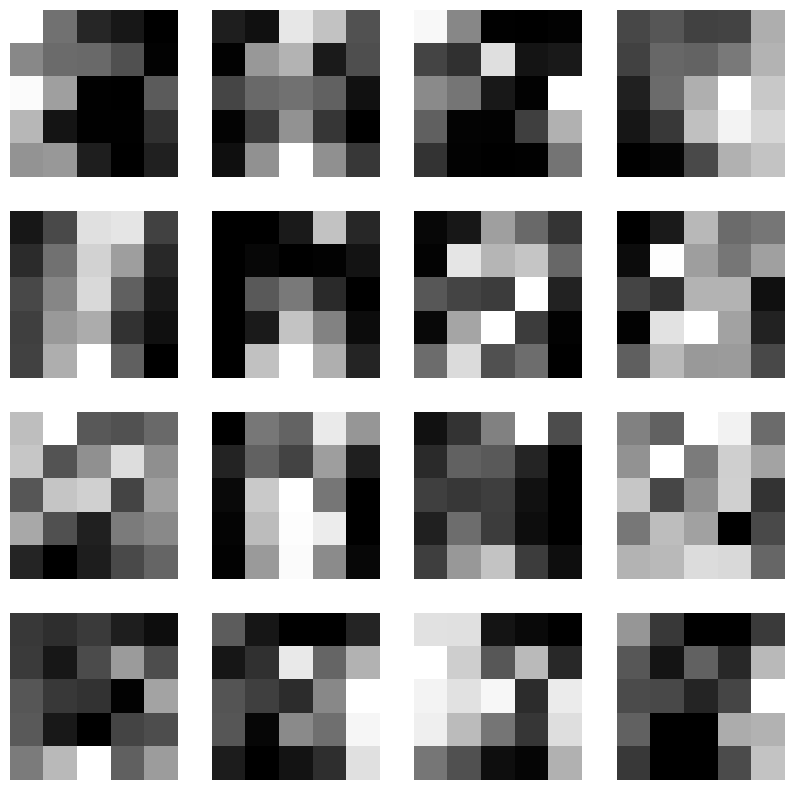

In [15]:
data,label = next(iter(test_loader))
a = model_load.net(data[0])
import torch
import matplotlib.pyplot as plt

# Example tensor (replace this with your actual tensor)
tensor = a

# Display each image in a 4x4 grid
num_images = tensor.size(0)
num_rows = 4
num_cols = num_images // num_rows + (num_images % num_rows > 0)

plt.figure(figsize=(10, 10))

for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(tensor[i].detach().numpy(), cmap='gray')  # Assuming the values are in the range [0, 1]
    plt.axis('off')

plt.show()


In [40]:
from torchvision import models 
vgg = models.resnet18()
summary(vgg)     

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

In [16]:
data,label = next(iter(train_loader))

tensor(7)


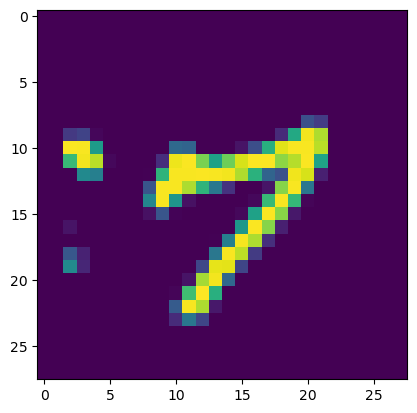

In [17]:
plt.imshow(data[2].reshape(28,28))
print(label[2]) 

In [18]:
out = clf(data[2:3,:,:,:])
_,pred = torch.max(out,1)
pred  

tensor([7])

In [1]:

! pip install numpy==1.20.0
import cv2 


In [55]:
img = cv2.imread(r'C:\Users\Ali\Desktop\9.png',0)
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0,1)])
img = transform(img)
out = clf(img.view(1,1,28,28)) 
_,pred = torch.max(out,1)
pred   

tensor([9])